In [2]:
import pandas as pd
from data_process.preprocessing import discretization, get_nodes_type, code_categories
from block_learning.train_bn import structure_learning, parameter_learning
from block_learning.partial_bn_train import connect_partial_bn, hierarchical_train, direct_connect
import seaborn as sns
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from block_learning.save_bn import save_structure, save_params
from block_learning.read_bn import read_structure, read_params
from block_learning.sampling import generate_synthetics, get_probability
from libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import visualizer

In [3]:
def grouped_barplot(df, cat, subcat, val, err):
    u = df[cat].unique()
    x = np.arange(len(u))
    subx = df[subcat].unique()
    offsets = (np.arange(len(subx))-np.arange(len(subx)).mean())/(len(subx)+1.)
    width= np.diff(offsets).mean()
    for i, gr in enumerate(subx):
        dfg = df[df[subcat] == gr]
        plt.bar(x+offsets[i], dfg[val].values, width=width, 
                label="{}".format(gr), yerr=dfg[err].values)
    plt.xlabel(cat)
    plt.ylabel(val)
    if isinstance(u[0], float):
        u = [round(_, 1) for _ in u]
        
    plt.xticks(x, u, rotation=90)
    plt.legend()
    plt.show()

In [4]:
def draw_comparative_hist(parameter: str, original_data: pd.DataFrame, sample: pd.DataFrame):
    df1 = pd.DataFrame()
    probs = get_probability(original_data, original_data, parameter)
        
    df1[parameter] = probs.keys()
    
    #print(df1[parameter])
    #print(np.unique(original_data[parameter]))
    
    df1['Probability'] = [p[1] for p in probs.values()]
    df1['Error'] = [p[2]-p[1] for p in probs.values()]
    df1['Data'] = 'Исходные данные'

    
    df2 = pd.DataFrame()
    probs = get_probability(sample, original_data, parameter)
    df2[parameter] =probs.keys()
    df2['Probability']  = [p[1] for p in probs.values()]
    df2['Error'] = [p[2]-p[1] for p in probs.values()]
    df2['Data'] = 'Синтетические данные'


    
    final_df = pd.concat([df1, df2])
    
    #print(final_df)
    
    grouped_barplot(final_df, parameter, 'Data', 'Probability', 'Error')
    plt.show()

In [5]:
data = pd.read_csv('data/final_dataset_no_posts_info.csv')
data.head(10)

,age,sex,is_closed,has_high_education,relation_status,number_of_relatives,len_of_about,number_of_activities,number_of_books,number_of_friends,...,driver,has_pets,cash_usage,gulyaka,zhavoronok,sum_act,top1,top2,top3,top4
0,34,1,0,1,1,2,14,1,1,911,...,0,0,0,1,0,1,Gifts & holidays,Music,History & politics,Purchase & sale
1,37,1,0,0,0,0,0,0,0,24,...,0,1,0,0,0,1,Purchase & sale,Gifts & holidays,Cooking,Love & relation
2,37,1,0,0,0,0,0,0,0,2535,...,0,0,0,0,0,0,History & politics,Gifts & holidays,Love & relation,Purchase & sale
3,39,1,0,1,4,0,0,1,1,291,...,0,0,0,1,0,2,History & politics,Gifts & holidays,Love & relation,Job & money
4,34,1,0,0,0,0,0,0,0,413,...,0,0,0,1,0,1,Gifts & holidays,Music,History & politics,Love & relation
5,36,0,0,0,0,0,0,0,0,175,...,1,0,0,0,0,1,Gifts & holidays,History & politics,Love & relation,Fitness & cosmetology
6,35,0,0,0,0,0,0,0,0,279,...,1,0,0,0,0,1,Gifts & holidays,History & politics,Music,Purchase & sale
7,41,0,0,0,0,0,0,0,0,134,...,1,0,0,0,0,1,Gifts & holidays,Love & relation,History & politics,Purchase & sale
8,34,0,0,1,4,4,0,1,4,177,...,1,0,0,0,0,2,Gifts & holidays,Love & relation,History & politics,Cooking
9,43,1,0,1,0,0,40,1,3,1540,...,0,0,0,0,0,0,Gifts & holidays,Love & relation,History & politics,Music


In [6]:
data.shape

(44736, 49)

In [7]:
data = data[['age',	'sex',	'has_high_education',	'relation_status',	'number_of_relatives','len_of_about',	'number_of_activities',	'number_of_books',	'number_of_interests',	'number_of_movies','top1','top2','top3','top4', 'nodes',	'edges',	'size',	'betweenness_centrality',	'density',	'eigenvector_centrality',	'degree_assortativity_coefficient', 'number_of_followers', 'max_tr',	'mean_tr',	'med_tr', 'parent',	'driver',	'has_pets',	'cash_usage']] #'posts_count',	'posts_per_month',	'likes_per_post',	'views_per_post',	'repost_ratio']]

In [8]:
discrete_data = discretization(data, 'kmeans', bins= 5, columns=['betweenness_centrality',	'density',	'eigenvector_centrality',	'degree_assortativity_coefficient','max_tr',	'mean_tr',	'med_tr'])#, 'posts_per_month', 'repost_ratio'])

In [9]:
new_data = code_categories(discrete_data, ['top1', 'top2', 'top3', 'top4'])

In [10]:
module1 = new_data[['age',	'sex',	'has_high_education',	'relation_status',	'number_of_relatives']]
module2 = new_data[['len_of_about',	'number_of_activities',	'number_of_books',	'number_of_interests',	'number_of_movies']]
module3 = new_data[['top1', 'top2', 'top3', 'top4']]
module4 = new_data[['nodes',	'betweenness_centrality',	'eigenvector_centrality', 'number_of_followers']]
module5 = new_data[['max_tr',	'mean_tr', 'parent',	'driver',	'has_pets',	'cash_usage']]
#module6 = new_data[['posts_per_month',	'likes_per_post',	'views_per_post',	'repost_ratio']]

In [11]:
node_type1 = get_nodes_type(data[['age',	'sex',	'has_high_education',	'relation_status',	'number_of_relatives']])
node_type1

{'age': 'disc',
 'sex': 'disc',
 'has_high_education': 'disc',
 'relation_status': 'disc',
 'number_of_relatives': 'disc'}

In [12]:
node_type2 = get_nodes_type(data[['len_of_about',	'number_of_activities',	'number_of_books',	'number_of_interests',	'number_of_movies']])
node_type2

{'len_of_about': 'disc',
 'number_of_activities': 'disc',
 'number_of_books': 'disc',
 'number_of_interests': 'disc',
 'number_of_movies': 'disc'}

In [13]:
node_type3 = get_nodes_type(data[['top1', 'top2', 'top3', 'top4']])
node_type3

{'top1': 'disc', 'top2': 'disc', 'top3': 'disc', 'top4': 'disc'}

In [14]:
node_type4 = get_nodes_type(data[['nodes',	'betweenness_centrality',	'eigenvector_centrality', 'number_of_followers']])
node_type4

{'nodes': 'disc',
 'betweenness_centrality': 'cont',
 'eigenvector_centrality': 'cont',
 'number_of_followers': 'disc'}

In [15]:
node_type5 = get_nodes_type(data[['max_tr',	'mean_tr', 'parent',	'driver',	'has_pets',	'cash_usage']])
node_type5

{'max_tr': 'cont',
 'mean_tr': 'cont',
 'parent': 'disc',
 'driver': 'disc',
 'has_pets': 'disc',
 'cash_usage': 'disc'}

In [13]:
node_type6 = get_nodes_type(data[['posts_per_month',	'likes_per_post',	'views_per_post',	'repost_ratio']])
node_type6

{'posts_per_month': 'disc',
 'likes_per_post': 'disc',
 'views_per_post': 'disc',
 'repost_ratio': 'disc'}

In [15]:
start = time.time()
bn1 = structure_learning(module1, 'MI', node_type1)

In [16]:
bn1

{'V': ['age',
  'sex',
  'has_high_education',
  'relation_status',
  'number_of_relatives'],
 'E': [['has_high_education', 'sex'],
  ['age', 'has_high_education'],
  ['number_of_relatives', 'has_high_education'],
  ['age', 'relation_status'],
  ['sex', 'relation_status']]}

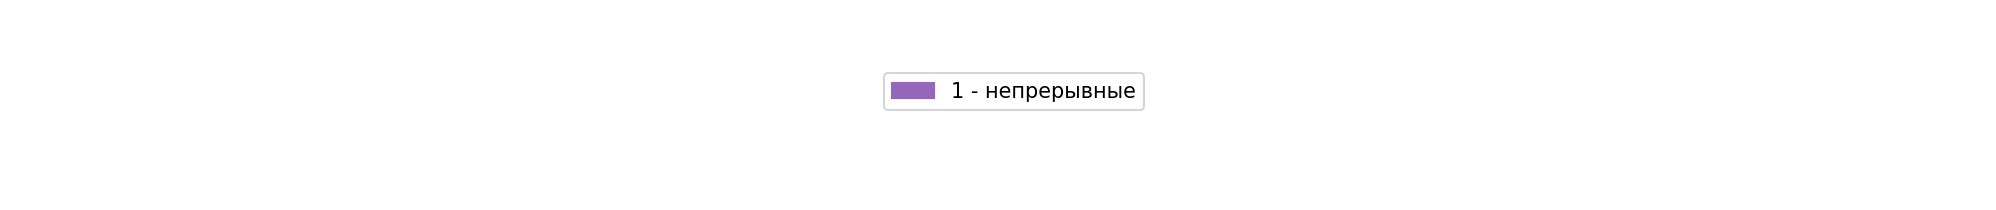

In [17]:
visualizer(bn1, node_type1)

In [57]:
param1 = parameter_learning(data[['age',	'sex',	'has_high_education',	'relation_status',	'number_of_relatives']], node_type1, bn1)

In [58]:
save_structure(bn1, 'skel1')
skel1 = read_structure('skel1')
save_params(param1, 'params1')
params1 = read_params('params1')
hybn1 = HyBayesianNetwork(skel1, params1)

In [59]:
end = time.time()
print(end - start)

1.3144323825836182


In [60]:
bn2 = structure_learning(module2, 'MI', node_type2)

In [61]:
bn2

{'V': ['len_of_about',
  'number_of_activities',
  'number_of_books',
  'number_of_interests',
  'number_of_movies'],
 'E': []}

In [62]:
param2 = parameter_learning(data[['len_of_about',	'number_of_activities',	'number_of_books',	'number_of_interests',	'number_of_movies']], node_type2, bn2)

In [63]:
save_structure(bn2, 'skel2')
skel2 = read_structure('skel2')
save_params(param2, 'params2')
params2 = read_params('params2')
hybn2 = HyBayesianNetwork(skel2, params2)


In [64]:
end = time.time()
print(end - start)

1.9848835468292236


In [65]:
bn3 = structure_learning(module3, 'MI', node_type3)
bn3

{'V': ['top1', 'top2', 'top3', 'top4'],
 'E': [['top1', 'top2'], ['top3', 'top2'], ['top1', 'top3'], ['top2', 'top4']]}

In [66]:
param3 = parameter_learning(data[['top1', 'top2', 'top3', 'top4']], node_type3, bn3)

In [67]:
save_structure(bn3, 'skel3')
skel3 = read_structure('skel3')
save_params(param3, 'params3')
params3 = read_params('params3')
hybn3 = HyBayesianNetwork(skel3, params3)

In [29]:
bn4 = structure_learning(module4, 'MI', node_type4)
bn4

{'V': ['nodes',
  'betweenness_centrality',
  'eigenvector_centrality',
  'number_of_followers'],
 'E': [['nodes', 'betweenness_centrality'],
  ['number_of_followers', 'betweenness_centrality'],
  ['nodes', 'eigenvector_centrality'],
  ['number_of_followers', 'eigenvector_centrality']]}

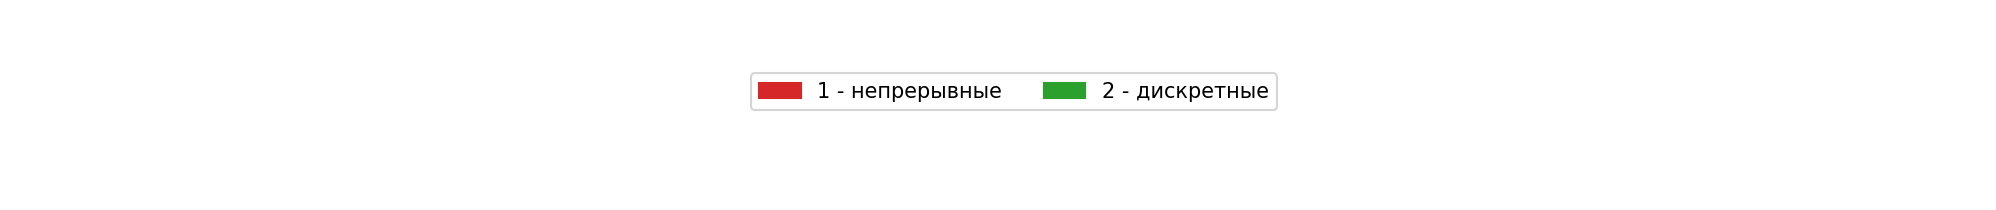

In [30]:
visualizer(bn4, node_type4)

In [69]:
param4 = parameter_learning(data[['nodes',	'betweenness_centrality',	'eigenvector_centrality', 'number_of_followers']], node_type4, bn4)

In [70]:
save_structure(bn4, 'skel4')
skel4 = read_structure('skel4')
save_params(param4, 'params4')
params4 = read_params('params4')
hybn4 = HyBayesianNetwork(skel4, params4)

In [71]:
bn5 = structure_learning(module5, 'MI', node_type5)

In [72]:
param5 = parameter_learning(data[['max_tr',	'mean_tr', 'parent',	'driver',	'has_pets',	'cash_usage']], node_type5, bn5)

In [73]:
save_structure(bn5, 'skel5')
skel5 = read_structure('skel5')
save_params(param5, 'params5')
params5 = read_params('params5')
hybn5 = HyBayesianNetwork(skel5, params5)

In [74]:
bn6 = structure_learning(module6, 'MI', node_type6)
bn6

{'V': ['posts_per_month', 'likes_per_post', 'views_per_post', 'repost_ratio'],
 'E': [['likes_per_post', 'posts_per_month'],
  ['views_per_post', 'posts_per_month'],
  ['views_per_post', 'repost_ratio'],
  ['posts_per_month', 'repost_ratio']]}

In [75]:
param6 = parameter_learning(data[['posts_per_month',	'likes_per_post',	'views_per_post',	'repost_ratio']], node_type6, bn6)

In [76]:
save_structure(bn6, 'skel6')
skel6 = read_structure('skel6')
save_params(param6, 'params6')
params6 = read_params('params6')
hybn6 = HyBayesianNetwork(skel6, params6)

In [77]:
hybn_1_2 = connect_partial_bn(hybn1, hybn2, data[['age',	'sex',	'has_high_education',	'relation_status',	'number_of_relatives', 'len_of_about',	'number_of_activities',	'number_of_books',	'number_of_interests',	'number_of_movies']], 'LV_1', 5)

In [79]:
hybn_1_3 = connect_partial_bn(hybn1, hybn3, data[['age',	'sex',	'has_high_education',	'relation_status',	'number_of_relatives', 'top1', 'top2', 'top3','top4']], 'LV_2', 5)

In [80]:
interest1 = generate_synthetics(hybn3, 25000)
interest2 = generate_synthetics(hybn_1_3, 25000)

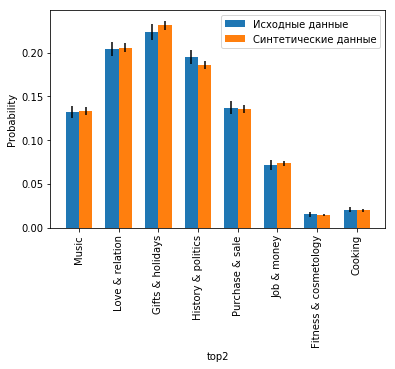

In [81]:
draw_comparative_hist('top2', data[['top1', 'top2', 'top3', 'top4']], interest2)

In [69]:
sample1_2 = generate_synthetics(hybn_1_2, 24747)
sample1_3 = generate_synthetics(hybn_1_3, 24747)

In [70]:
data['LV_1'] = sample1_2['LV_1']
data['LV_2'] = sample1_3['LV_2']

In [71]:
hybn1_2_3 = hierarchical_train(hybn_1_2, hybn_1_3, data[['age',	'sex',	'has_high_education',	'relation_status',	'number_of_relatives', 'len_of_about',	'number_of_activities',	'number_of_books',	'number_of_interests',	'number_of_movies','top1', 'top2', 'top3','LV_1','LV_2']])

In [72]:
sample1_2_3 = generate_synthetics(hybn1_2_3, 24747)

In [82]:
direct_connect([hybn1, hybn2, hybn3, hybn4, hybn5, hybn6], new_data[['age',	'sex',	'has_high_education',	'relation_status',	'number_of_relatives', 'len_of_about',	'number_of_activities',	'number_of_books',	'number_of_interests',	'number_of_movies','top1', 'top2', 'top3','top4', 'nodes',	'betweenness_centrality',	'eigenvector_centrality', 'number_of_followers','max_tr',	'mean_tr', 'parent',	'driver',	'has_pets',	'cash_usage', 'posts_per_month',	'likes_per_post',	'views_per_post',	'repost_ratio']])

  0%|          | 17/1000000 [01:30<1477:20:01,  5.32s/it]

[['age', 'has_pets'],
 ['sex', 'relation_status'],
 ['sex', 'has_high_education'],
 ['has_high_education', 'number_of_books'],
 ['has_high_education', 'number_of_interests'],
 ['has_high_education', 'number_of_movies'],
 ['has_high_education', 'len_of_about'],
 ['has_high_education', 'driver'],
 ['relation_status', 'driver'],
 ['relation_status', 'parent'],
 ['number_of_activities', 'has_high_education'],
 ['number_of_activities', 'relation_status'],
 ['number_of_activities', 'number_of_relatives'],
 ['top1', 'top3'],
 ['top1', 'top2'],
 ['top2', 'top4'],
 ['top3', 'top2'],
 ['nodes', 'eigenvector_centrality'],
 ['nodes', 'betweenness_centrality'],
 ['nodes', 'top1'],
 ['nodes', 'likes_per_post'],
 ['eigenvector_centrality', 'betweenness_centrality'],
 ['number_of_followers', 'nodes'],
 ['number_of_followers', 'has_pets'],
 ['number_of_followers', 'parent'],
 ['parent', 'driver'],
 ['driver', 'age'],
 ['has_pets', 'top1'],
 ['cash_usage', 'parent'],
 ['cash_usage', 'max_tr'],
 ['cash_u